In [4]:
# Setup from initial notebook setup. Run once!

# Duckdb is a SQL engine that allows us to execute powerful, analytics-friendly
# queries against local or remote databases and flat files.
import duckdb
import pandas as pd
from IPython.display import display # to adjust Pandas dataframe layouts
import matplotlib.pyplot as plt # for plotting

# Create a database file on disk
conn = duckdb.connect('example.db')
# Enable remote access
conn.sql("INSTALL httpfs")
conn.sql("LOAD httpfs")
# This database file points to files totaling multiple GBs,
# but it's only about 300KB itself. The `ATTACH` command
# gives us access to views that sit on top of remote Parquet files.
try:
  conn.sql("ATTACH 'https://data.baseball.computer/dbt/bc_remote.db' (READ_ONLY)")
except duckdb.BinderException:
  # This command will fail if you run it more than once because it already exists,
  # in which case we don't need to do anything
  pass

conn.sql("USE bc_remote")
conn.sql("USE main_models")

# Connect to a local DB to store remote results
local = duckdb.connect(database = "weird-stats.db", read_only = False)

In [5]:
stats = conn.sql("""
SELECT 
    player_id, 
    people.first_name, 
    people.last_name, 
    game_id, 
    wins, 
    blown_saves,
    --- MAX(substr(game_id,4,4)) 
FROM 
    player_game_pitching_stats 
    JOIN people 
        USING (player_id) 
WHERE 
    blown_saves > 0 
    AND wins > 0 
--- GROUP BY 
---    1,3,2
ORDER BY 
    substr(game_id,4,8) desc, 
    3 desc,
    2 desc
    """).df()

local.sql("""
CREATE TABLE IF NOT EXISTS BSwins as (SELECT
*
FROM
stats)""")

local.sql("""SELECT * FROM BSWins""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,player_id,first_name,last_name,game_id,wins,blown_saves
0,bousc001,Caleb,Boushley,MIL202309290,1,1
1,clase001,Emmanuel,Clase,CLE202309220,1,1
2,stept002,Trevor,Stephan,CLE202309210,1,1
3,stepr002,Robert,Stephenson,TBA202309190,1,1
4,scott003,Tanner,Scott,MIA202309190,1,1
...,...,...,...,...,...,...
4241,smitf106,Frank,Smith,CIN191205100,1,1
4242,bentr102,Rube,Benton,SLN191205010,1,1
4243,harmb101,Bob,Harmon,CHN191204260,1,1
4244,hamie101,Earl,Hamilton,SLA191204220,1,1


In [6]:
bswinsdate = local.sql("""
SELECT
    DATE(concat_ws('-',substr(game_id, 4, 4),substr(game_id,8,2), substr(game_id,10,2))) gameDate,
    COUNT(*) games,
    string_agg(concat_ws(' ', first_name, last_name),',\n') players
FROM
    BSWins
GROUP BY 1
ORDER BY
    2 desc, 1 desc
""").df()
display(bswinsdate.style.set_properties(**{'white-space' : 'pre-wrap'}))


In [13]:
yearly = local.sql("""
SELECT
    year(gameDate) gameyear,
    SUM(Games) totalGames
FROM
    bswinsdate
GROUP BY 1
ORDER BY year(gameDate) desc
""").df()

<Axes: xlabel='gameyear'>

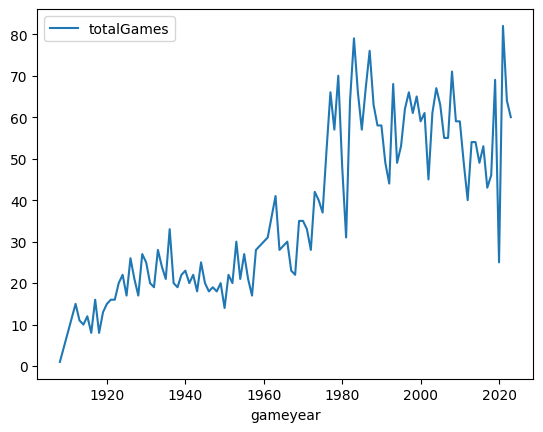

In [18]:
yearly.plot(x="gameyear",y="totalGames")

In [21]:
# Close at the end
local.close()
conn.close()